In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline  

# Algorithm

## Digital Filter
All weight is given to the most probable state. Just one state is updatetd echt step beacuse of that.

In [90]:
class TwoClassFilterDigital(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        self.dataCount = [0,0]
        self.dataSum = [0,0]
        
    def computeTheta(self, _x, _theta, _weight, _sum, _count):
        theta = _theta
        #compute updated var
        theta[1] = 1/(_weight/theta[1] + _count/1)# maybe find a better way for the likelihood var = 1
        #compute updated mean
        theta[0] = (((_weight * theta[0]) / theta[1]) + _sum/theta[1])/(1/theta[1] + _count/theta[1])
        return theta
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        unnormZ0 = likelihood0 * (self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1])
        unnormZ1 = likelihood1 * (self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1])
        zSum = unnormZ0 + unnormZ1
        self.z = [unnormZ0/zSum, unnormZ1/zSum]
        #print "z", self.z
        
        if(self.z[0]>self.z[1]):
            self.dataSum[0] += _x
            self.dataCount[0] += 1
            self.theta0 = self.computeTheta(_x, self.theta0, 1, self.dataSum[0], self.dataCount[0])
        else:
            self.dataSum[1] += _x
            self.dataCount[1] += 1
            self.theta1 = self.computeTheta(_x, self.theta1, 1, self.dataSum[1], self.dataCount[1])
        #print "theta0", self.theta0
        #print "theta1", self.theta1
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

<type 'float'>
0.8
<type 'float'>
0.2
<type 'float'>
0.1


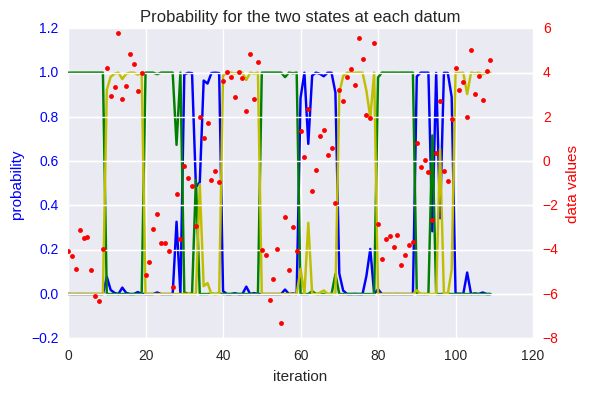

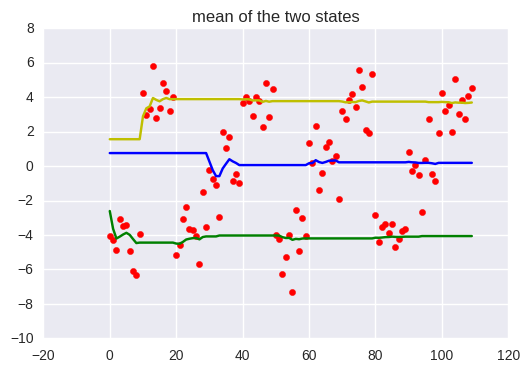

<function matplotlib.pyplot.show>

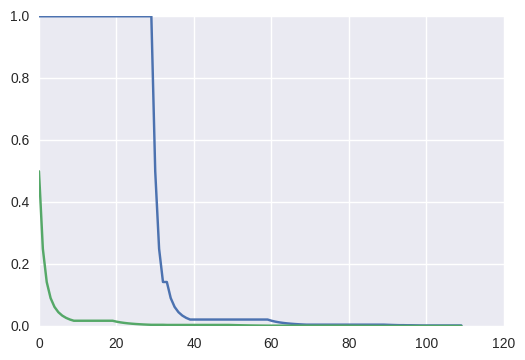

In [112]:
def TestData(mean=[4,-4, 0], var=[1,1, 1.3], n=10, skips=5):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%3],var[i%3],n))
    return data

data = TestData(skips=10)
fA = ManyClassFilterDigital(3, np.matrix([[0.8, 0.1, 0.1],[0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]))
filterData = []
z0 = []
z1 = []
z2 = []
mean0 = []
mean1 = []
mean2 = []
var0 = []
var1 = []

for i,x in enumerate(data[:]):
    d = fA.update(x)
    #print d
    #print ""
    filterData.append(d)
    z0.append(d[0]['z'])
    z1.append(d[1]['z'])
    z2.append(d[2]['z'])
    mean0.append(d[0]['theta'][0])
    mean1.append(d[1]['theta'][0])
    mean2.append(d[2]['theta'][0])
    var0.append(d[0]['theta'][1])
    var1.append(d[1]['theta'][1])

fig, ax1 = plt.subplots()
ax1.set_ylim([-0.2,1.2])
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(range(0,len(data[:])), z0, 'b')
ax1.plot(range(0,len(data[:])), z1, 'g')
ax1.plot(range(0,len(data[:])), z2, 'y')
ax1.set_xlabel('iteration')
ax1.set_ylabel('probability', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(range(0,len(data[:])), data[:], 'r.')
ax2.set_ylabel('data values', color='r')
ax2.tick_params('y', colors='r')
plt.title("Probability for the two states at each datum")
plt.show()

plt.plot(mean0[:], 'b')
plt.plot(mean1[:], 'g')
plt.plot(mean2[:], 'y')
plt.scatter(range(0,len(data[:1000])),data[:1000], color='red')
plt.title('mean of the two states')
plt.show()

plt.plot(var0)
plt.plot(var1)
plt.show



In [41]:
print z0

[]


Why does the variance not response to changepoints:
The variance is a meassure for the belief in the mean of a state. It does not refere to the belief in the current state.

## Analogue Filter
weights each datum according to the probability $P(x_i|z)$

In [19]:
class TwoClassFilterAnalogue(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        self.dataWeightedSum = [0,0]
        self.dataCount = [0,0]
        self.dataSum = [0,0]
        
    def computeTheta(self, _x, _theta, _weight, _sum, _count):
        theta = _theta
        #compute updated var
        theta[1] = 1/(_weight/theta[1] + _count/1)# maybe find a better way for the likelihood var = 1
        #compute updated mean
        theta[0] = (((_weight * theta[0]) / theta[1]) + _sum/1)/(1/theta[1] + _count/1)
        return theta
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        unnormZ0 = likelihood0 * (self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1])
        unnormZ1 = likelihood1 * (self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1])
        zSum = unnormZ0 + unnormZ1
        self.z = [unnormZ0/zSum, unnormZ1/zSum]
        
        #if(self.z[0]>self.z[1]):
        if True:
            self.dataSum[0] += _x*likelihood0
            self.dataCount[0] += likelihood0
            self.theta0 = self.computeTheta(_x, self.theta0, 1, self.dataSum[0], self.dataCount[0])
        #else:
            self.dataSum[1] += _x*likelihood1
            self.dataCount[1] += likelihood1
            self.theta1 = self.computeTheta(_x, self.theta1, 1, self.dataSum[1], self.dataCount[1])
        #print "theta0", self.theta0
        #print "theta1", self.theta1
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

## Evaluation
1. Create Data
2. how long for finding mean
3. false positve rate of $z$
4. different prior values
5. different number of states

In [85]:
def TestData(mean=[4,-4], var=[1,1], n=10, skips=5):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

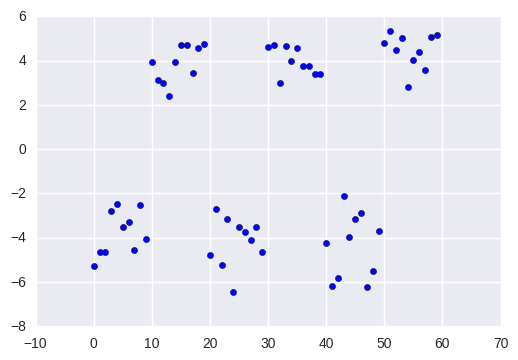

In [86]:
data = TestData()
plt.scatter(range(0,len(data)), data)

In [88]:
def evalDigitalFilter(mean=[5,-5], var=[1,1], n=10):
    data = TestData(mean, var, n)
    fA = TwoClassFilterDigital()
    filterData = []
    z0 = []
    z1 = []
    mean0 = []
    mean1 = []
    var0 = []
    var1 = []
    
    for i,x in enumerate(data[:]):
        filterData.append(fA.update(x))
        z0.append(filterData[-1][0][0])
        z1.append(filterData[-1][0][1])
        mean0.append(filterData[-1][1][0])
        mean1.append(filterData[-1][2][0])
        var0.append(filterData[-1][1][1])
        var1.append(filterData[-1][2][1])
    
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    ax1.plot(range(0,len(data[:])), z0, 'b')
    ax1.plot(range(0,len(data[:])), z1, 'g')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(range(0,len(data[:])), data[:], 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()

    plt.plot(mean0[:1000])
    plt.plot(mean1[:1000])
    plt.scatter(range(0,len(data[:1000])),data[:1000], color='red')
    plt.title('mean of the two states')
    plt.show()

    plt.plot(var0)
    plt.plot(var1)
    plt.show

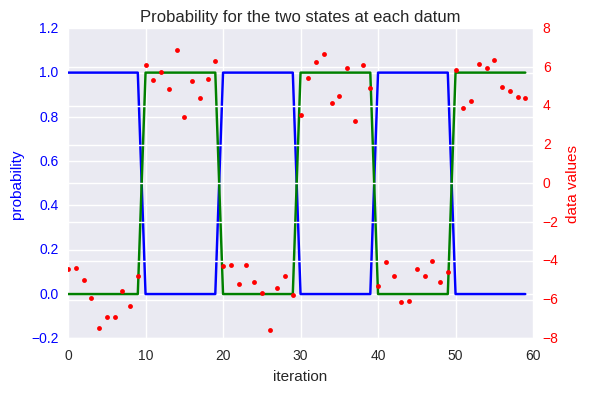

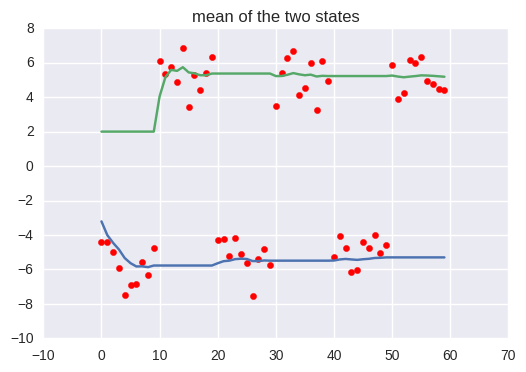

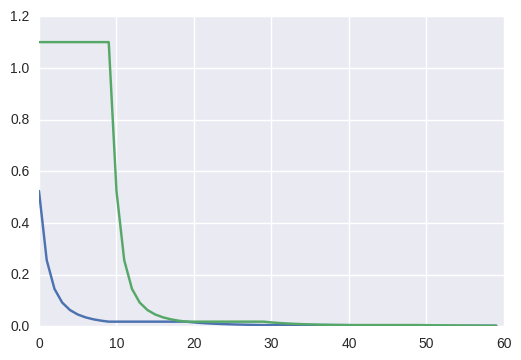

In [91]:
evalDigitalFilter()

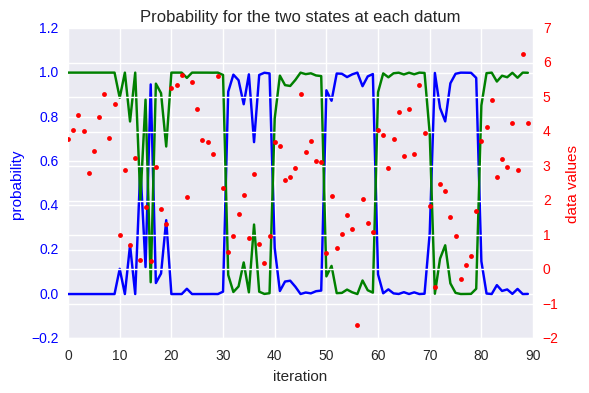

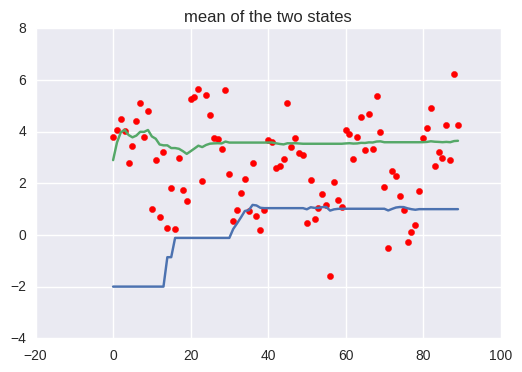

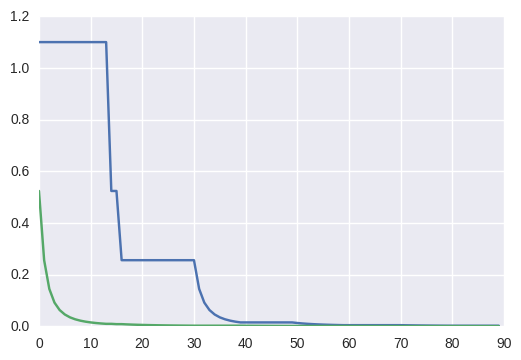

In [68]:
evalDigitalFilter([4,1])

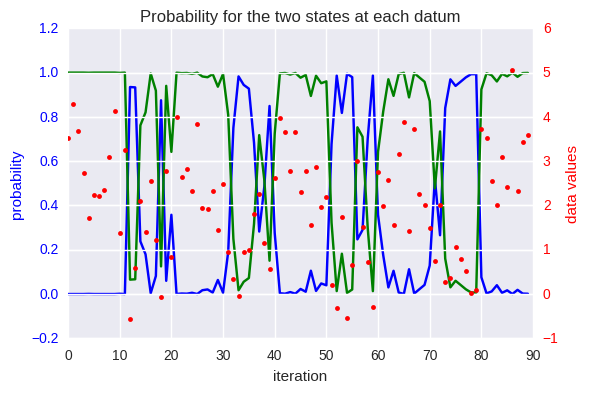

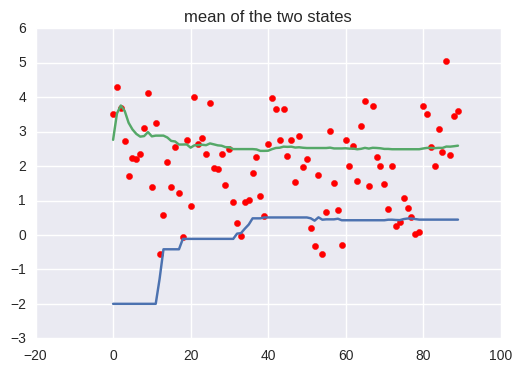

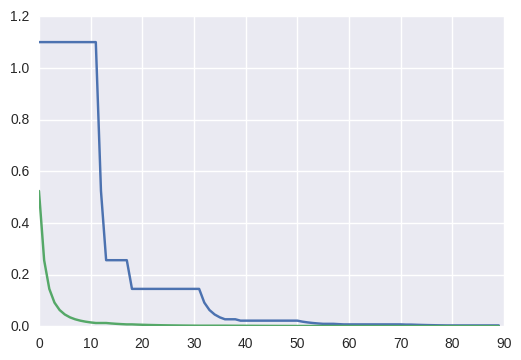

In [44]:
evalDigitalFilter([3,1])

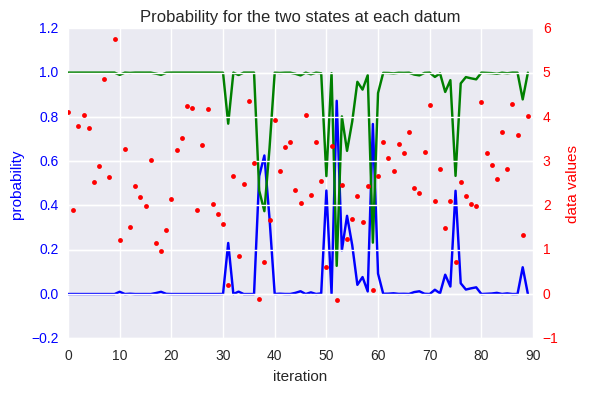

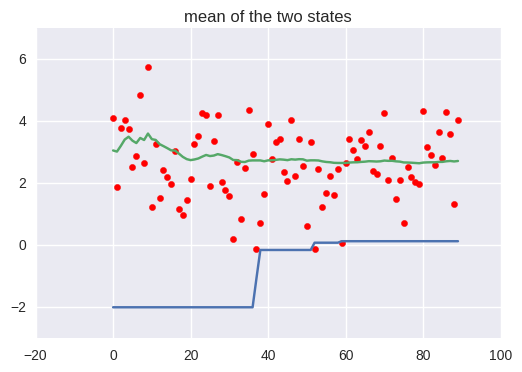

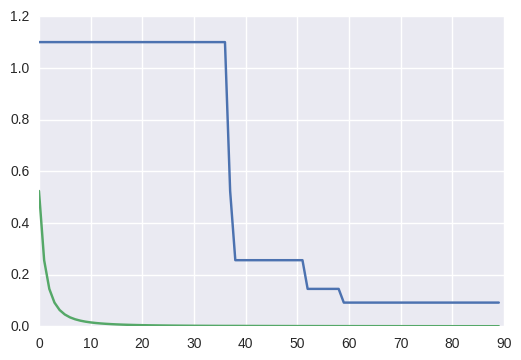

In [45]:
evalDigitalFilter([3,2])

### Too many states in the Algorithm

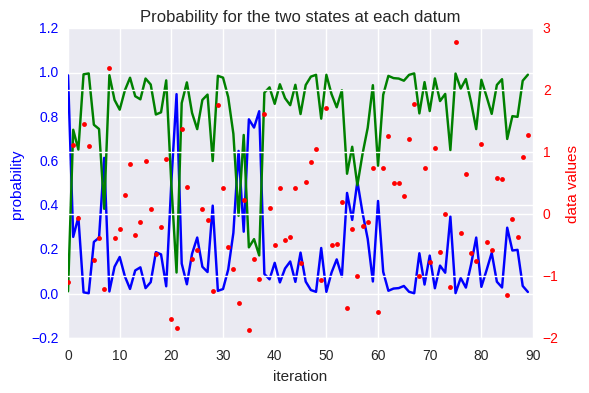

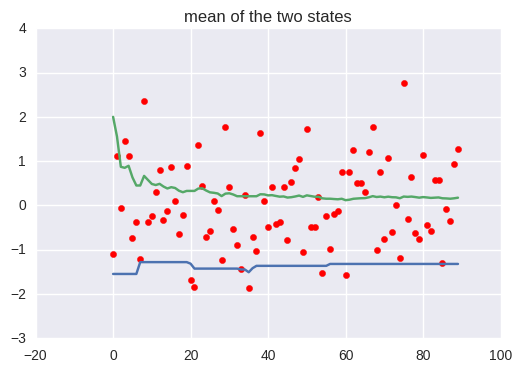

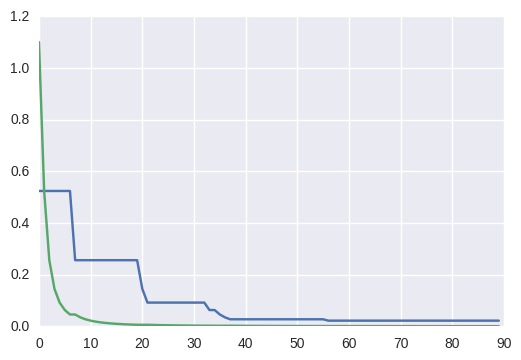

In [69]:
evalDigitalFilter([0,0])

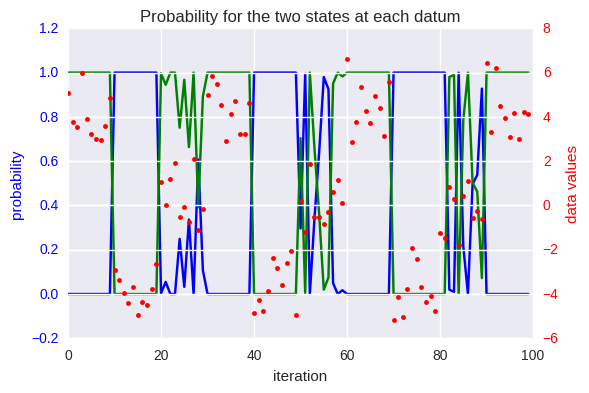

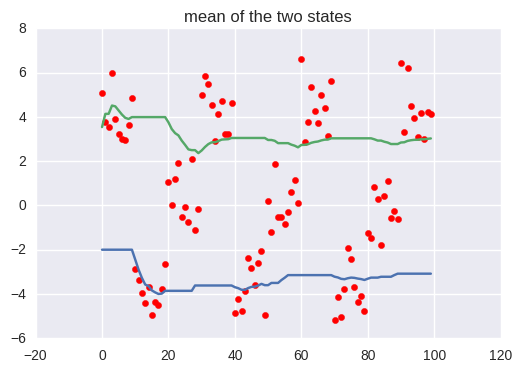

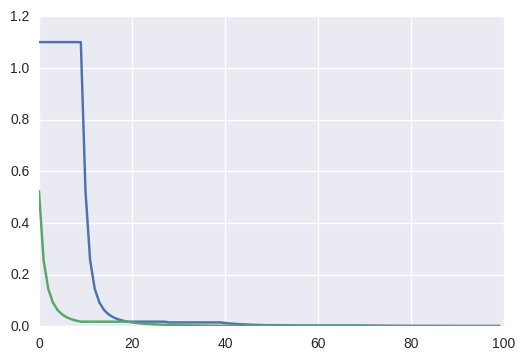

In [71]:
def TestData3(mean=[4,-4, 0], var=[1,1,1], n=10):
    data = np.random.normal(mean[0],var[0],n)
    data = np.append(data, np.random.normal(mean[1],var[1],n))
    data = np.append(data, np.random.normal(mean[2],var[2],n))
    data = np.append(data, np.random.normal(mean[0],var[0],n))
    data = np.append(data, np.random.normal(mean[1],var[1],n))
    data = np.append(data, np.random.normal(mean[2],var[2],n))
    data = np.append(data, np.random.normal(mean[0],var[0],n))
    data = np.append(data, np.random.normal(mean[1],var[1],n))
    data = np.append(data, np.random.normal(mean[2],var[2],n))
    data = np.append(data, np.random.normal(mean[0],var[0],n))
    return data

def evalDigitalFilter3(mean=[5,-5], var=[1,1], n=10):
    data = TestData3()
    fA = TwoClassFilterDigital()
    filterData = []
    z0 = []
    z1 = []
    mean0 = []
    mean1 = []
    var0 = []
    var1 = []
    
    for i,x in enumerate(data[:]):
        filterData.append(fA.update(x))
        z0.append(filterData[-1][0][0])
        z1.append(filterData[-1][0][1])
        mean0.append(filterData[-1][1][0])
        mean1.append(filterData[-1][2][0])
        var0.append(filterData[-1][1][1])
        var1.append(filterData[-1][2][1])
    
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    ax1.plot(range(0,len(data[:])), z0, 'b')
    ax1.plot(range(0,len(data[:])), z1, 'g')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(range(0,len(data[:])), data[:], 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()

    plt.plot(mean0[:1000])
    plt.plot(mean1[:1000])
    plt.scatter(range(0,len(data[:1000])),data[:1000], color='red')
    plt.title('mean of the two states')
    plt.show()

    plt.plot(var0)
    plt.plot(var1)
    plt.show
    
evalDigitalFilter3()